### Using Transfer Learning and Tensorflow to Classify Dog Breeds



In [ ]:
# !unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision"

# End to end multiclass Dog breed classification

This notebook bulids an end to end multiclass image classifier using Tensorflow 2.0 and tensorflow hub.

## 1. Problem

Identifiying the breed of a dig guven an image of a dog.

When Iam sitting at the cage and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we are using is from Kaggles dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We are dealing with images (unstructured data) so its probably best we use deep learning/transfer learning.
* There are about 120 breeds of dogs so 120 different classes.
* There are around 10,000+ images in the training set and these images have labels.
* There are around 10,000+ images in the test set and these images have no labels because we want to predict them.

### Get our workspace ready

* Import tensorflow 2.x .
* Import tensorflow hub.
* Make sure we are using GPU.

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("tensorflow ", tf.__version__)
print("HUB", hub.__version__)

# Check for GPU availability
print("GPU", "available yes" if tf.config.list_physical_devices("GPU") else "not available")


tensorflow  2.2.0
HUB 0.8.0
GPU available yes


You might be wondering what a GPU is or why we need one. The short story is, a GPU is a computer chip which is faster at doing numerical computing. And since machine learning is all about finding patterns in numbers, that's what we're after.

Running this for the first time in Colab will let us know there's no GPU available.

This is because by default Colab runs on a computer located on Google's servers which doesn't have a GPU attached to it.

But we can fix this going to runtime and then changing the runtime type:

Go to Runtime.
Click "Change runtime type".
Where it says "Hardware accelerator", choose "GPU" (don't worry about TPU for now but feel free to research them).
Click save.
The runtime will be restarted to activate the new hardware, so you'll have to rerun the above cells.
If the steps have worked you should see a print out saying "GPU available".
If you want an example of how much a GPU speeds up computing, Google Colab have a demonstration notebook available.

**Getting data ready**

Since much of machine learning is getting your data ready to be used with a machine learning model, we'll take extra care getting it setup.

There are a few ways we could do this. Many of them are detailed in the Google Colab notebook on I/O (input and output).

And because the data we're using is hosted on Kaggle, we could even use the Kaggle API.

This is great but what if the data you want to use wasn't on Kaggle?

One method is to upload it to your Google Drive, mount your drive in this notebook and import the file.

**Accessing the data**


Now the data files we're working with are available on our Google Drive, we can start to check it out.

Let's start with labels.csv which contains all of the image ID's and their assosciated dog breed (our data and labels).

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     c388a84f93ba4fb28c7b1a7a880474f1  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
# How many image sare there of each breed?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

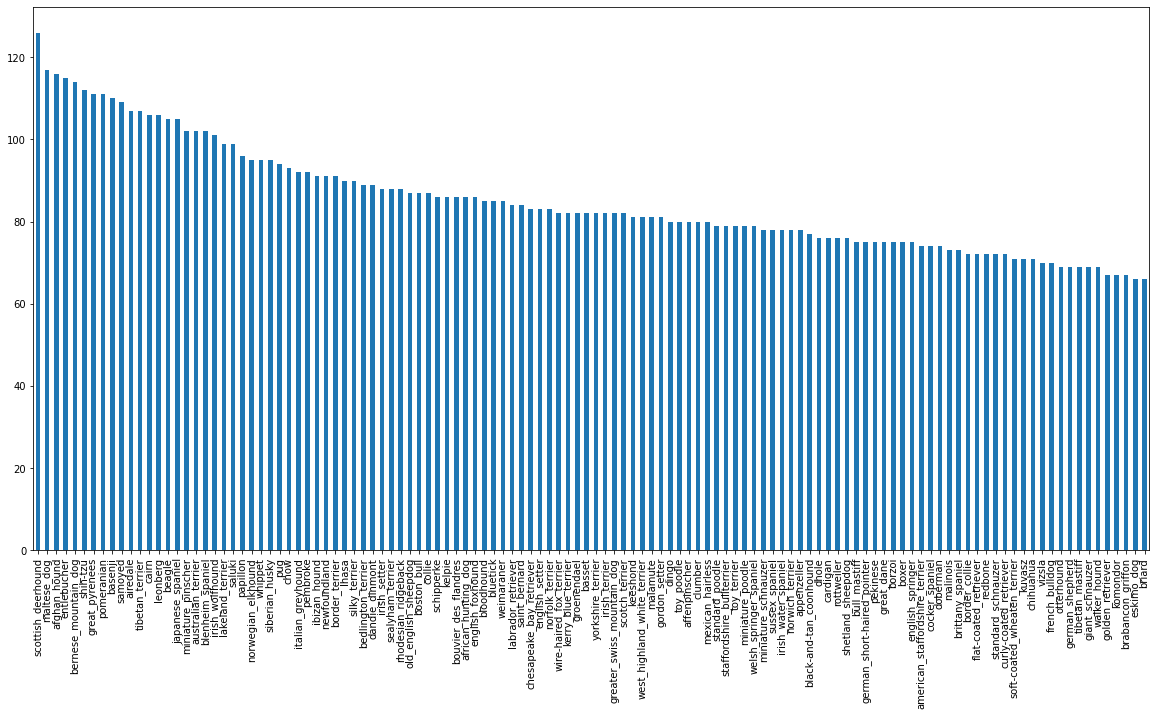

In [ ]:
#Visualize
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

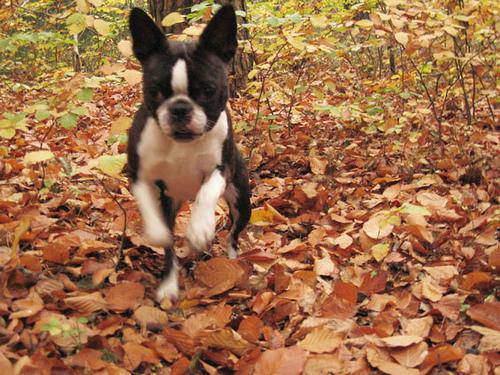

In [ ]:
# Lets view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their label

Lets get a list of all of our image file pathname

In [ ]:
# Create a pathname form image Ids
filenames = ["drive/My Drive/Dog Vision/train/" + fname +".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of filenmaes matches number of acual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("File names matches actual amount of files")
else:
  print("File names no matches ")

File names matches actual amount of files


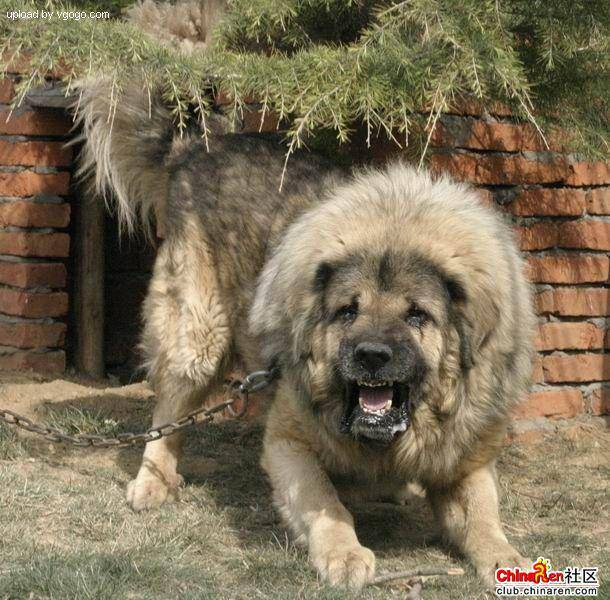

In [ ]:
#One more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

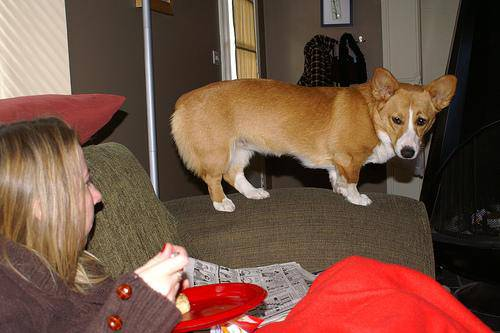

In [ ]:
Image(filenames[10000])

In [ ]:
labels_csv["breed"][10000]

'pembroke'

Since we have got our training image file path in a list, Lets prepare our labels

In [ ]:
labels = labels_csv["breed"]
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
import numpy as np
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
len(unique_breeds)

120

In [ ]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set

Since the dataset from Kaggle doesn't come up with validation, we can make our own validation set.

In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

We are going to start off experimenting with ~1000 images and increase the needed.

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
NUM_IMAGES

1000

In [ ]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Check out the training data (image file paths and labels)
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images (turning images into Tensors)

To preprocess ournimages into Tensors we are going to write a function which does a few things:
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a varibale, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modifies `image`

Before we do, lets see what importing an  image looks like.


In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42]) # read in an image
image.shape

(257, 350, 3)

In [ ]:

image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [ ]:
image.max()

255

In [ ]:
image.min()

0

In [ ]:

tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we have seen what an image looks like as as Tensor, lets make a function to preprocss them.

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a varibale, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize and Resize the `image` to be a shape of (224, 224)
5. Return the modifies `image`

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into Tensor
  """

  # read in ann image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into  numerical tensow with 3 colour channels(RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Conver the colour channels values to from 0 to 255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our  desired value(`224`, `224`)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Lets say you are trying to proocess 10,000+ images in one go, they all mighnt not fit into memory.

So thats why we do about 32 images  at a time (We can also manually adjust the size of batch size)

Inorder to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (`image`, `label`).




In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
(process_image(filenames[42]), tf.constant(y[42]))


(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we have got a way to turn our data into tuples of tensors
in the form: (`image`, `label`), lets make a function to turn all our data 
into batches

In [ ]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## VisualiZing data batches

Our data is now in batches , however these can be a little hard to understand/comprehend, lets visualize it.

In [ ]:
import matplotlib.pyplot as plt

# Create  a functipm fpr viewing images in a data batch.
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.

  """

  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 for displaying 25 images
  for i in range(25):
    # Create subplots 5 rows, 5 columns
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as plot title
    plt.title(unique_breeds[labels[i].argmax()])
    # turn the grid lines off
    plt.axis("off")

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.7922948 , 0.8275889 , 0.8158242 ],
          [0.8123885 , 0.8476826 , 0.8359179 ],
          [0.79904485, 0.83433896, 0.82257426],
          ...,
          [0.8117648 , 0.8470589 , 0.8352942 ],
          [0.8117648 , 0.8470589 , 0.8352942 ],
          [0.8117648 , 0.8470589 , 0.8352942 ]],
 
         [[0.80639017, 0.8416843 , 0.8299196 ],
          [0.8028001 , 0.83809423, 0.8263295 ],
          [0.803159  , 0.8384531 , 0.8266884 ],
          ...,
          [0.81568635, 0.85098046, 0.83921576],
          [0.81568635, 0.85098046, 0.83921576],
          [0.81568635, 0.85098046, 0.83921576]],
 
         [[0.80020356, 0.8354977 , 0.823733  ],
          [0.8046996 , 0.8399937 , 0.828229  ],
          [0.80884004, 0.84413415, 0.83236945],
          ...,
          [0.81818986, 0.853484  , 0.84171927],
          [0.81818986, 0.853484  , 0.84171927],
          [0.81818986, 0.853484  , 0.84171927]],
 
         ...,
 
         [[0.7951923 , 0.8108786 , 0.806957  ],
          [0.80049

In [ ]:
len(train_images), len(train_labels)

(32, 32)

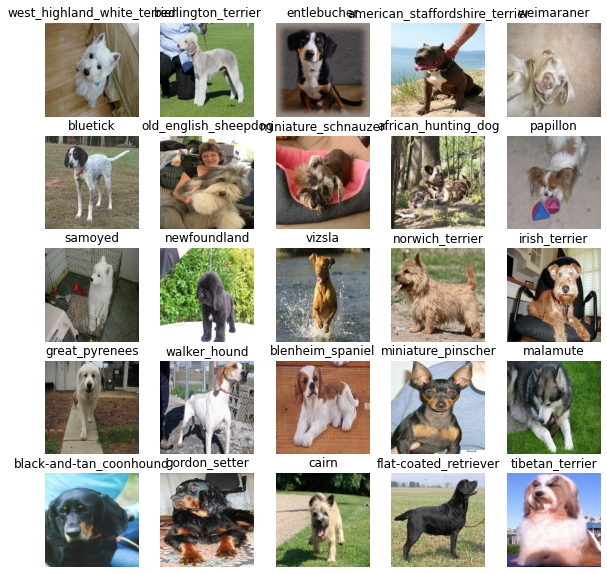

In [ ]:
# Now lets visualize our data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

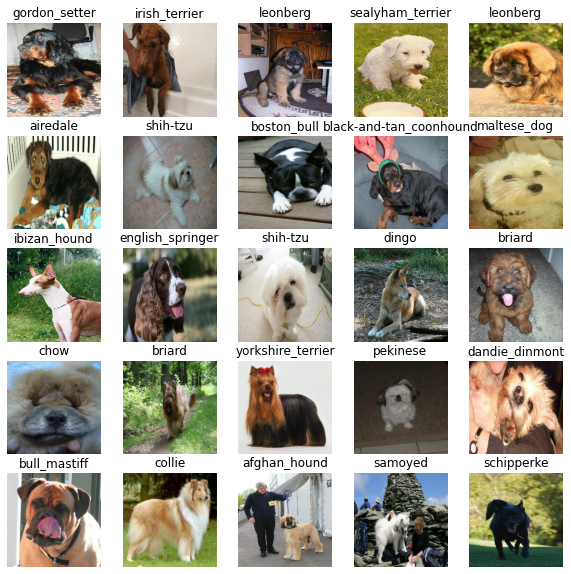

In [ ]:
# Now lets visualize our valdation set
val_images, val_labels = next(train_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Buliding a Model

Before we build a model, there are few things we need to define:
* The input shape (our images shape, in the form of Tensors)to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The url of the model we want to use from tensorflow hub:
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)
# Setup model URL from Tensordlow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we have got our inputs, outputs and model ready to go.
Lets put them together into Keras deep learning model!

Knowing this, lets create a function which:
* Takes the input shape, output shape and the model we have chosen as parameters.
* Define the layers in a Keras model in sequential fashion(do this first, then the other, then only the other).
* Compiles the model (says it should be evaluated and improved).
* Builds the mode(tells the model the input shape it will be getting).
* Returns the model.

All of these steps can be found here:
https://www.tensorflow.org/guide/keras/sequential_model

In [ ]:

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # Layer 1 input layer
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") # Layer 2 Output layer
                               
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stop improving.

We will create two callbacks, one for Tensorboard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a tensorboard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our models `fit()` function.
3.Visualize our models training logs wiht the `%tensorboard%` magic function(we will do this after model training).

In [ ]:
# Load Tensorboard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for stroting tensorboard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Earlys topping helps stop our model form overfitting by stopping training if a certain evaluation metrics stops.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping



In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.


In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we are still running on GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Lets create a funciton which trains our model

* Create a model using `create_model()`.
* Setup a Tensorboard callback using `create_tensorboard_callback()`.
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for and the callbacks we would like to use.
* Return the mode.

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytitme we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model
  

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 284s 11s/step - loss: 4.5576 - accuracy: 0.1025 - val_loss: 3.4065 - val_accuracy: 0.2800
Epoch 2/100
25/25 [==============================] - 5s 207ms/step - loss: 1.6310 - accuracy: 0.6762 - val_loss: 2.2155 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 5s 210ms/step - loss: 0.5551 - accuracy: 0.9500 - val_loss: 1.7314 - val_accuracy: 0.5850
Epoch 4/100
25/25 [==============================] - 5s 206ms/step - loss: 0.2437 - accuracy: 0.9887 - val_loss: 1.5633 - val_accuracy: 0.6300
Epoch 5/100
25/25 [==============================] - 5s 208ms/step - loss: 0.1455 - accuracy: 0.9950 - val_loss: 1.4984 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 5s 212ms/step - loss: 0.0994 - accuracy: 1.0000 - val_loss: 1.4562 - val_accuracy: 0.6300
Epoch 7/100
25/25 [==============================

**Question** : It looks like our model is overfittinh because its performing far better on the  trianing dataset than the validation datatset what are some ways to prevent our model form overfitting in deep learning neural network?

**Note** : Overfitting to begin with is a good thing~ It means our model is training.

### Checking the TensorBoard Logs

The TensorBoard magic function will access the logs directory we created earlier and visualize its contents.


In [ ]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and evaluating predictions using trained model

In [ ]:
# Make predicitons on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 134ms/step


array([[3.5160731e-03, 8.9107358e-05, 2.2646172e-03, ..., 1.1549696e-03,
        4.5430494e-05, 3.5887326e-03],
       [3.9528450e-03, 9.4973773e-04, 1.4259731e-02, ..., 4.8279084e-04,
        1.1270700e-03, 1.6735107e-04],
       [8.6611857e-05, 1.3088618e-04, 7.7953273e-06, ..., 4.5473578e-05,
        2.8070071e-05, 1.3857613e-04],
       ...,
       [5.1503426e-05, 1.9142908e-04, 1.2591407e-04, ..., 2.0783530e-04,
        1.7988826e-04, 3.0702507e-04],
       [4.5648348e-03, 4.8888108e-04, 4.2475757e-04, ..., 1.2301860e-04,
        1.2673628e-04, 1.0495027e-02],
       [3.9481086e-04, 7.5794436e-05, 9.4682479e-04, ..., 2.9625038e-03,
        2.2086225e-04, 2.1853873e-05]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(y_val), len(unique_breeds)

(200, 120)

In [ ]:
np.sum(predictions[0])

1.0

In [ ]:
# First prediciton
index = 0
print(predictions[index])
print(f"Max value (probability of predicitons): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[3.51607311e-03 8.91073578e-05 2.26461724e-03 9.70917536e-05
 1.17803567e-04 7.44595091e-05 1.24374954e-02 1.63781398e-03
 1.09772396e-03 1.04169804e-03 9.21273953e-04 5.60092332e-04
 5.83663495e-05 2.28582576e-04 3.46049870e-04 1.57422118e-03
 6.76091120e-04 1.66286916e-01 4.54162800e-05 8.79832660e-05
 2.80898472e-04 1.59529434e-03 2.74834183e-05 7.15545902e-04
 1.03057071e-04 5.15471445e-04 3.33218962e-01 2.19425056e-04
 2.38256311e-04 1.07494346e-03 4.77773538e-05 1.03369751e-03
 2.70086690e-04 1.30464716e-04 7.35039357e-05 2.31688339e-02
 1.46443117e-05 4.14756796e-04 6.13744924e-05 2.26107353e-04
 1.02693192e-03 1.47837218e-05 3.15183250e-04 5.78593346e-04
 6.05081405e-05 4.30508313e-04 1.01878664e-04 1.98839611e-04
 6.17754471e-04 1.71962078e-04 8.20573769e-05 3.61841630e-05
 4.02813865e-04 2.73250538e-04 2.76915380e-04 3.44325999e-05
 1.69250445e-04 5.35995513e-03 5.89704432e-04 1.81213260e-01
 1.59579189e-03 5.87104078e-05 1.91093318e-03 1.01549238e-04
 2.30026868e-04 2.378169

In [ ]:
# First prediciton
index = 42
print(predictions[index])
print(f"Max value (probability of predicitons): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[9.1866939e-04 1.5426087e-04 4.7516347e-05 1.2512994e-04 4.2257681e-03
 2.2452680e-04 2.2434433e-04 1.5617119e-03 1.4587701e-02 1.4715740e-01
 7.4753130e-05 6.4757587e-05 1.4806162e-03 1.3734207e-03 2.5354321e-03
 2.2187757e-03 3.5133657e-05 1.9918881e-04 2.4672982e-04 2.1649328e-04
 3.0355526e-05 1.9928534e-03 1.1031941e-04 9.0575173e-05 1.6669441e-02
 9.4023169e-05 8.4777515e-05 1.5427734e-04 1.4968152e-04 7.0455710e-05
 6.8129611e-04 2.6940787e-04 4.6471792e-05 5.0486044e-05 2.4170923e-04
 7.2270177e-06 4.8096565e-04 3.8884446e-04 3.5684548e-05 3.0076414e-01
 1.5974003e-04 5.8108250e-05 4.6080216e-03 5.0402818e-05 4.7427363e-04
 6.5413726e-05 7.1848201e-04 3.2940821e-04 2.3820619e-05 1.3642227e-03
 1.6838145e-04 1.3833011e-04 5.8962614e-04 6.2782085e-03 3.4373799e-05
 1.7627446e-03 1.8974637e-04 2.4771438e-05 2.5993306e-04 3.0499687e-05
 1.0156406e-04 6.9532415e-04 1.7228345e-05 1.1262903e-04 1.1279682e-04
 3.5900277e-05 1.9239735e-04 2.3789338e-03 3.2520897e-04 2.7037824e-05
 7.670

In [ ]:
unique_breeds[17]

'border_terrier'

In [ ]:
unique_breeds[113]

'walker_hound'

Having the above functionality is great but we want too be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Predition probabilities also know as confidence levels.

In [ ]:
# Turn prediction probabilities into their respective label(easier to understand).

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediciton probabilities into a label.
  """

  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of predicition probabilities
pred_label = get_pred_label(predictions[8])
pred_label

'saint_bernard'

In [ ]:
pred_label = get_pred_label(predictions[113])
pred_label

'lakeland_terrier'

In [ ]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Now since our validation data is still in a batch dataset, we will have tot unbatchify t=it to make predictions on the validation images and then compare those predictions to the validation labels or truth labels

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """

  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
get_pred_label(val_labels[0])

'affenpinscher'

Now we have got ways to get :
* Predictions labes.
* Validation labels (truth labels).
* Valiadtion images.

Lets make some function to make these all a bit visualise.

We will create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.


In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truht and images for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color = "red"

  # Chnage plot title to be predicited, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label), color=color)

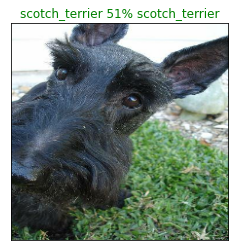

In [ ]:
plot_pred(prediction_probabilities = predictions,
          labels=val_labels,
          images=val_images)

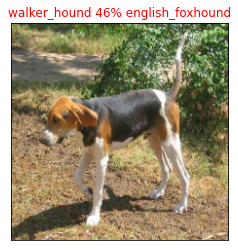

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=42)

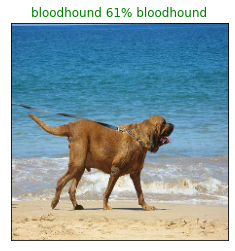

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=100)

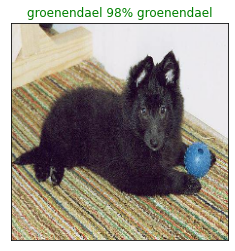

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we have got one function to visulaize our models top predicitons, lets make another to viow our models top 10 predictions

This functions will:
* Take an input of prediction probabilities array and a ground truth array and an integer.
* Find the prediction using `get_pred_label()`
* Find the top 10:
    * Prediction probabilities indexes.
    * Prediction probabilities values.
    * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth labels for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup a plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

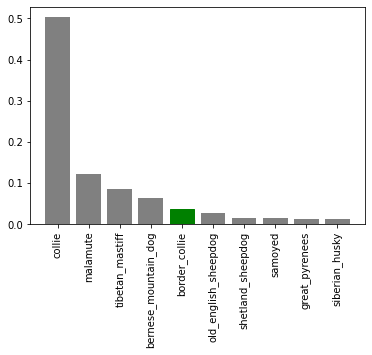

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we have got some functions to help us visualize our predictions and evaluate our model, lets check out a few

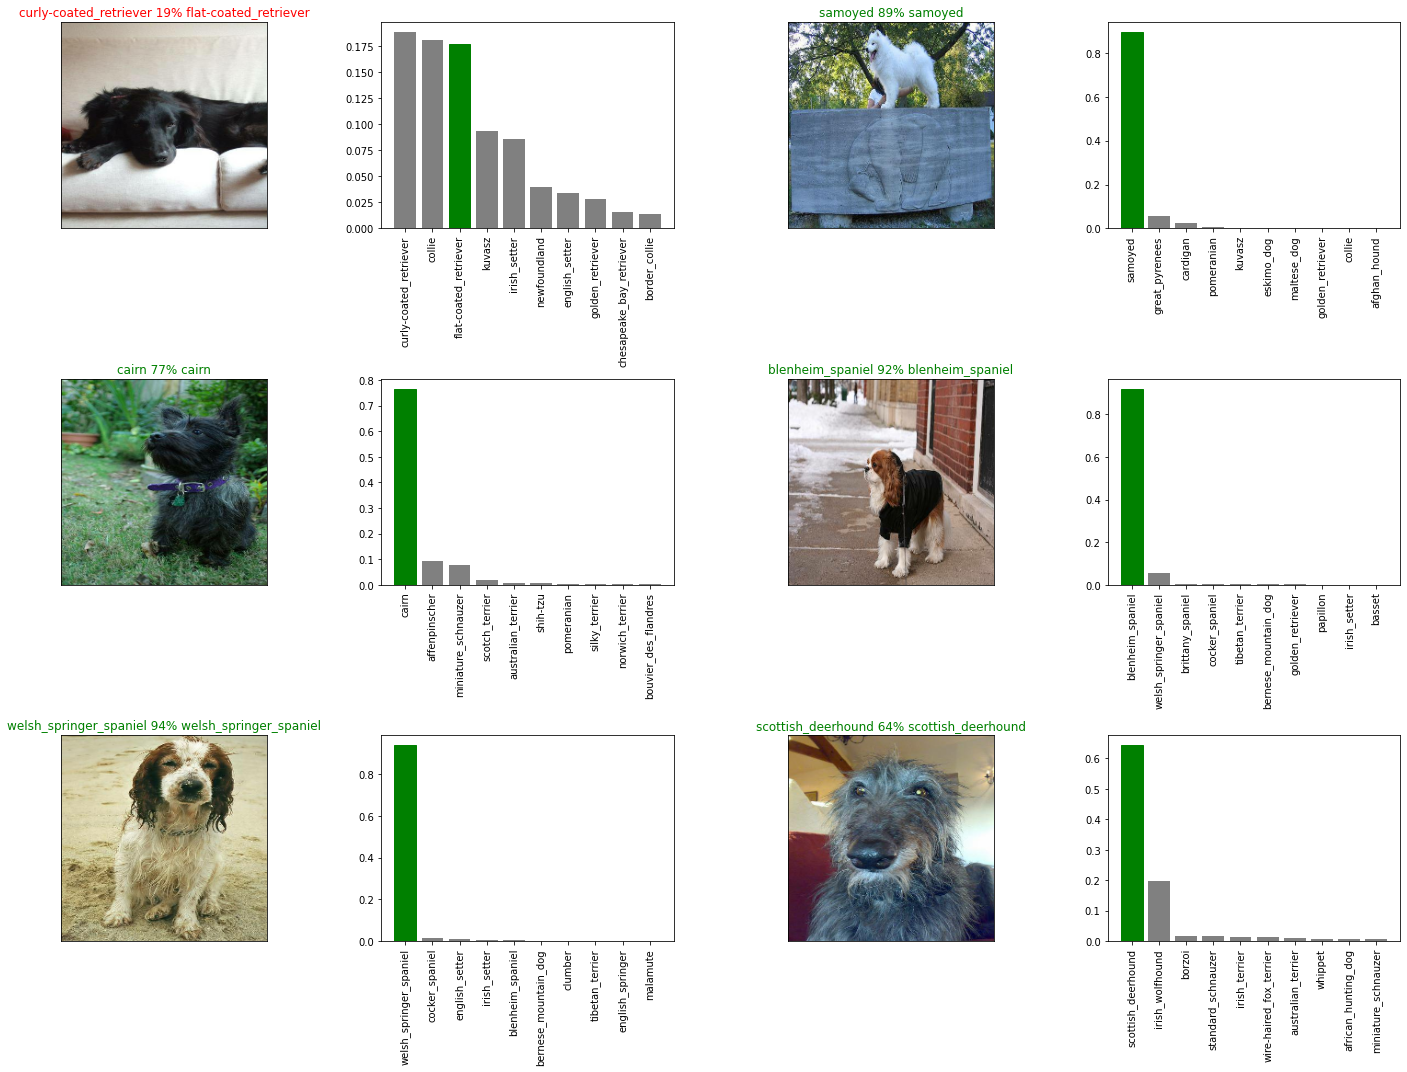

In [ ]:
# Lets check out a few predictiosn and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge**: How would you create a confusion matrix with our model predictions and true labels?

## Saving and loading a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """ 
  Saves a given model in a models directoory and appends a suffix(string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # Save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load the saved model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from {model_path}....")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we have got functions to save and load our model.\
Lets check it on our model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="100-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200726-05471595742457-100-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200726-05471595742457-100-images-mobilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('drive/My Drive/Dog Vision/models/20200726-05471595742457-100-images-mobilenetv2-Adam.h5')

Loading saved model from drive/My Drive/Dog Vision/models/20200726-05471595742457-100-images-mobilenetv2-Adam.h5....


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 134ms/step - loss: 1.3577 - accuracy: 0.6650


[1.3576927185058594, 0.6650000214576721]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 130ms/step - loss: 1.3577 - accuracy: 0.6650


[1.3576927185058594, 0.6650000214576721]

## Training the model on the full dataset

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with thhe full data set

full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
# Create a full model call backs
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we cant monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)


**Note:** Running the cell below will take a little while may take upto 30 minutes beacuse the GPU we are using in the runtime has to load all of the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 3352s 10s/step - loss: 1.3751 - accuracy: 0.6637
Epoch 2/100
320/320 [==============================] - 52s 163ms/step - loss: 0.4086 - accuracy: 0.8834
Epoch 3/100
320/320 [==============================] - 53s 164ms/step - loss: 0.2399 - accuracy: 0.9345
Epoch 4/100
320/320 [==============================] - 52s 163ms/step - loss: 0.1543 - accuracy: 0.9637
Epoch 5/100
320/320 [==============================] - 52s 164ms/step - loss: 0.1079 - accuracy: 0.9772
Epoch 6/100
320/320 [==============================] - 52s 163ms/step - loss: 0.0787 - accuracy: 0.9869
Epoch 7/100
320/320 [==============================] - 53s 166ms/step - loss: 0.0581 - accuracy: 0.9924
Epoch 8/100
320/320 [==============================] - 51s 161ms/step - loss: 0.0466 - accuracy: 0.9940
Epoch 9/100
320/320 [==============================] - 52s 161ms/step - loss: 0.0381 - accuracy: 0.9955
Epoch 10/100
320/320 [==============================] - 52s 162m

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200726-07171595747824-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200726-07171595747824-full-image-set-mobilenetv2-Adam.h5'

In [ ]:
loaded_full_model = load_model("drive/My Drive/Dog Vision/models/20200726-07171595747824-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from drive/My Drive/Dog Vision/models/20200726-07171595747824-full-image-set-mobilenetv2-Adam.h5....


## Making predictions on the test dataset

Sinc our model has been trained on the images in the form of tensor batches, to make predictions on the test data, we will have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take alist of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we will:
* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and settingthe `test_data` parameter to `True` since th etest data do not have labels.
* Make a predictions array by passing the test batches to `predict` method called on our model

In [ ]:
# Load the test image filename
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/edca6e9a7f6f35f9b0313d8aaaf844be.jpg',
 'drive/My Drive/Dog Vision/test/f328ba9a36da80caceea391ed1a87164.jpg',
 'drive/My Drive/Dog Vision/test/ef5c93599bcc330fd9642266d9650309.jpg',
 'drive/My Drive/Dog Vision/test/ec89476b99aab390011acee436f9642a.jpg',
 'drive/My Drive/Dog Vision/test/e959f03017afd7952e7635131387dd87.jpg',
 'drive/My Drive/Dog Vision/test/f01df7641b237cd177d71fdb8db9bd58.jpg',
 'drive/My Drive/Dog Vision/test/f540547111a9b6bda288b694a5536702.jpg',
 'drive/My Drive/Dog Vision/test/e917abf625ad6ba5b8a0e59bd23e8818.jpg',
 'drive/My Drive/Dog Vision/test/f1b634511c0ca2fcdf53c9c30f3358c9.jpg',
 'drive/My Drive/Dog Vision/test/f3cbc8bcd54963296f75377d6fe931d3.jpg']

In [ ]:
# Create test data batches
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run about ~1hour.

In [ ]:
# Make predicitions on test data batch usinng the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                     verbose=1)

In [ ]:
# Save predictions as Numpy array to csv file for later access
#np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [ ]:
# Load predictions from csv files
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

array([[1.61196489e-09, 3.44086413e-12, 2.32834394e-11, ...,
        1.06917716e-13, 1.58530451e-08, 1.52161670e-06],
       [3.17894322e-10, 3.20088262e-14, 1.85374840e-10, ...,
        7.00588814e-08, 1.88822238e-08, 2.56980937e-10],
       [4.27301083e-09, 1.84139528e-13, 1.11784948e-09, ...,
        2.71949238e-12, 2.23927123e-06, 7.41860809e-11],
       ...,
       [4.47232779e-10, 4.28004029e-07, 4.11986996e-08, ...,
        4.65437893e-07, 8.21722967e-10, 8.86002116e-09],
       [3.50528079e-11, 1.94377336e-03, 1.44941642e-10, ...,
        1.56135718e-06, 6.13228721e-08, 7.32120961e-12],
       [1.23221771e-08, 3.08354520e-09, 1.87174110e-10, ...,
        8.16165635e-10, 9.98905063e-01, 6.73740752e-09]])

In [ ]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for kaggle

Looking at the Kaggle sample submission , we find that it wants our models prediction output in a dataFrame with an ID and column for each different dog breeds.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we will:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image IDs from their filepaths.
* Add data to each of the dog breed columns
* Export the DataFrame as CSV to submit to Kaggle.

In [ ]:
# Create  a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
# Append test image IDs to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [ ]:
test_ids

['edca6e9a7f6f35f9b0313d8aaaf844be',
 'f328ba9a36da80caceea391ed1a87164',
 'ef5c93599bcc330fd9642266d9650309',
 'ec89476b99aab390011acee436f9642a',
 'e959f03017afd7952e7635131387dd87',
 'f01df7641b237cd177d71fdb8db9bd58',
 'f540547111a9b6bda288b694a5536702',
 'e917abf625ad6ba5b8a0e59bd23e8818',
 'f1b634511c0ca2fcdf53c9c30f3358c9',
 'f3cbc8bcd54963296f75377d6fe931d3',
 'ea0a6a12e3f6f65e4f742b258a0ffe30',
 'f56185baca63dfc073ca82bee5bf24e4',
 'f1e0d9aa421de4c518baddf3d7bea598',
 'ef627a04965eda29fc3761b1f663aef1',
 'ef0209bcfab48f72f71c9d1b8648aa45',
 'eb06356375888d41903fff14ef7c4104',
 'e9f25d81c8fa96020a77a1f3148d0d3c',
 'eb2f2ad0f785a7c85f8c62969be71e2a',
 'f16ce30657f7dec9cf08597bbce2ffdb',
 'fb0eb902d8e532e4e126c951c405989f',
 'f7266c7c804418bf6ea1f644b4efc33c',
 'f643ae3f2d8e15aebe4a417367b3f14e',
 'fe2aaa06247c9c040b23ac9ef6529654',
 'f6e209dbbd97aadf518f16d18a807ffb',
 'fd7148fdd18ad0b4d1c5ff4c4c35f99d',
 'fcb000b1746ad358f4d99b55571d7b8e',
 'f7d2a66a4b9ea177fde652290498e5b2',
 

In [ ]:
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id  ... yorkshire_terrier
0  edca6e9a7f6f35f9b0313d8aaaf844be  ...               NaN
1  f328ba9a36da80caceea391ed1a87164  ...               NaN
2  ef5c93599bcc330fd9642266d9650309  ...               NaN
3  ec89476b99aab390011acee436f9642a  ...               NaN
4  e959f03017afd7952e7635131387dd87  ...               NaN

[5 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  edca6e9a7f6f35f9b0313d8aaaf844be  ...       1.52162e-06
1  f328ba9a36da80caceea391ed1a87164  ...       2.56981e-10
2  ef5c93599bcc330fd9642266d9650309  ...       7.41861e-11
3  ec89476b99aab390011acee436f9642a  ...       6.13453e-11
4  e959f03017afd7952e7635131387dd87  ...       1.31887e-06

[5 rows x 121 columns]

In [ ]:
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetv2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we will:
* Get the filepaths of our own images.
* Turn the filpaths into data batches using `create_data_batches()`. And since our custom images wont have labels we set the `test_data` parameter to True.
Pass the custom image data batch to our models `predict()` method.
* Convert the prediciton output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [ ]:
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/1.jpg']

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Make predictions on the custom data
custom_preds  = loaded_full_model.predict(custom_data)

In [ ]:
custom_preds.shape

(1, 120)

In [ ]:
# Get custom image prediction labels 
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['tibetan_terrier']

In [ ]:
# Get custom images function wont work since there aret labels.. maybe we could fix this layer
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

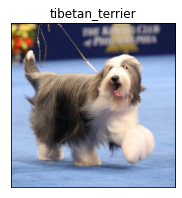

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)